In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import scipy.optimize

%matplotlib inline 

import emcee

import seaborn as sns
import pandas as pd

In [2]:
dls_data = np.loadtxt("100nm.dat", skiprows=1)

# Data is in columns based on angle the data is taken at. The first row labels these columns

tau = dls_data[:,0]
intensity_20 = dls_data[:,1]
intensity_40 = dls_data[:,2]
intensity_60 = dls_data[:,3]
intensity_80 = dls_data[:,4]
intensity_100 = dls_data[:,5]
intensity_120 = dls_data[:,6]
intensity_140 = dls_data[:,7]
intensity_160 = dls_data[:,8]

# Since the instrument stops taking data at the end and drops to 0, get rid of the last 40 points
intensity_20 = intensity_20[:(len(intensity_20)-40)]
intensity_40 = intensity_40[:(len(intensity_40)-40)]
intensity_60 = intensity_60[:(len(intensity_60)-40)]
intensity_80 = intensity_80[:(len(intensity_80)-40)]
intensity_100 = intensity_100[:(len(intensity_100)-40)]
intensity_120 = intensity_120[:(len(intensity_120)-40)]
intensity_140 = intensity_140[:(len(intensity_140)-40)]
intensity_160 = intensity_160[:(len(intensity_160)-40)]

tau = tau[:(len(tau)-40)]

#Load in the angles
dls_data = np.loadtxt("100nm.dat", usecols=(1,2,3,4,5,6,7,8))
phi = dls_data[0,:]
phi = phi*(np.pi/180) # scattering angle in radians

In [3]:
# First, I need to assume uniformm error bars in the y direction. 
# Let's say that the intensity autocorrelation function has a constant uncertainty of +-5% of the value

sig_g_20 = intensity_20*0.05
sig_g_40 = intensity_40*0.05
sig_g_60 = intensity_60*0.05
sig_g_80 = intensity_80*0.05
sig_g_100 = intensity_100*0.05
sig_g_120 = intensity_120*0.05
sig_g_140 = intensity_140*0.05
sig_g_160 = intensity_160*0.05

In [4]:
all_angles= []
all_intensity =[]
all_sig = []
all_tau = []

for j in range(0, 8):
    for i in range(0, len(intensity_20)):
        all_angles = np.append(all_angles, phi[j])

        
list_of_data = [intensity_20, intensity_40, intensity_60, intensity_80, intensity_100, intensity_120, intensity_140, intensity_160]
for item in list_of_data:        
    for i in range(0, len(item)):     
        all_intensity = np.append(all_intensity, item[i])

list_of_error = [sig_g_20, sig_g_40, sig_g_60, sig_g_80, sig_g_100, sig_g_120, sig_g_140, sig_g_160]
for item in list_of_error:        
    for i in range(0, len(item)):     
        all_sig = np.append(all_sig, item[i])

for j in range(0, 8):
    for i in range(0, len(tau)):
        all_tau = np.append(all_tau, tau[i])



In [5]:
# Now define the log of the liklihood function using the assumption that the prior is equal probablity
def log_prior(theta):
    # returns log of prior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Set a uniform prior, but within boundaries. It is not equally likely that the baseline is 1 million as it is
    # that it is one. All values must be positive
    if 0 < A < 10.0 and 0.0 < D < 100. and 0 < B < 10.0:
        return 0.0  # Since the probability is 1, this returns 0.
    else:
        return -np.inf # Since the probability is 0 in this region, this returns - infinity.
    
    
def log_likelihood(theta, tau, phi, g, sig_g):
    # returns the log of the likelihood function

    # theta: model parameters (specified as a tuple)
    # tau
    # g: measurements (autocorrelation function)
    # sig_g: uncertainties on measured data, set to be +- 5% of the value
    
    A, D, B = theta # unpack the model parameters
    
    # Using the model A*np.e**(-D* (4 pi n / lam * sin(phi/2) )**2 *tau) + B, define the log of the likelihood function as
    # ln (L) = K - 1/2 * Sum [(y- function)^2 / sigma^2] 
    # ln (L) = K - 1/2 Chi^2
    #q = ((4*np.pi * n) /(lam)) * np.sin(z/2)    
    
    n = 1.333 # refractive index
    
    m = (4*np.pi * n * np.sin(phi/2))**2 # where m is a stand in for the angle dependent portion

    residual = (g - A*np.e**(-D*m*tau) - B)**2
    chi_square = np.sum(residual/(sig_g**2))
    
    # the constant K is determined by the Gaussian function 
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sig_g**2)))
        
    
    return constant - 0.5*chi_square


def log_posterior(theta, tau, phi, g, sig_g):
    # returns log of posterior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Bayes Theorem: Posterior = Prior * likelihood
    # Ln (Posterior) = Ln (Prior ) + Ln (Likelihood)
    return log_prior(theta) + log_likelihood(theta, tau, phi, g, sig_g)

In [6]:
ndim = 3
nwalkers = 50
nsteps = 500


ls_result = [0.37613228, 18.35, 1] # A, D, B
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [7]:
# Can be given the angle either as a single value, or as an array
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(all_tau, all_angles, all_intensity, all_sig))

%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 4.09 s, sys: 27.7 ms, total: 4.12 s
Wall time: 4.32 s
Done


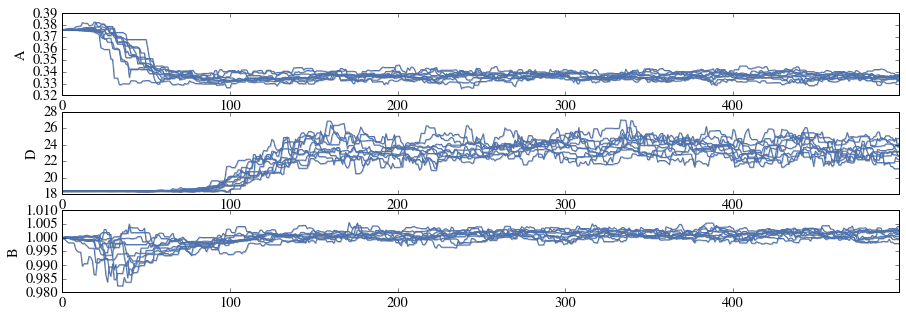

In [9]:
plt.style.use('seaborn-deep')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
fig, (ax_A, ax_D, ax_B) = plt.subplots(3)
ax_A.set(ylabel='A')
ax_D.set(ylabel='D')
ax_B.set(ylabel='B')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_D)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_B)

In [11]:
# Since it takes about 150 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,150:,:]

# reshape the samples into a 1D array where the colums are A, D, and B
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'D': traces[1], 'B': traces[2]})

# calculate the MAP and values using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,B,D
0.16,0.334196,0.999521,22.582121
0.50,0.337007,1.001073,23.549077
0.84,0.339945,1.002556,24.526263


In [12]:
# D = D / lam^2

lam = 658e-9 # wavelength in meters
D = 23.467937*lam**2
print D

1.01607718753e-11


In [13]:
# To find the radius, use the relationship D = kT/(6*pi*eta*R)

k = 1.38065e-23 # Boltzmann's constant, J/K (joules per kelvin)
T = 293.08 # Kelvin, roomtemp
eta = 10.016e-4 # viscosity of water, Pa s (pascal seconds) at temperature of 293.08 Kelvin

R = k*T / (6*np.pi*eta*D)
print "Radius: ", R

Radius:  2.10934510889e-08


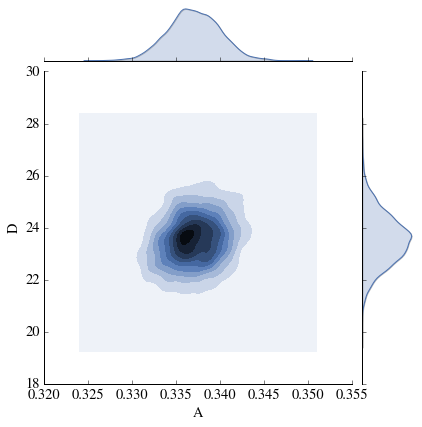

In [15]:
# Obviously this error bar model is allowing for this fit, but let's look at the shape of the pdf as
joint_kde = sns.jointplot(x='A', y='D', data=parameter_samples, kind='kde', stat_func=None)

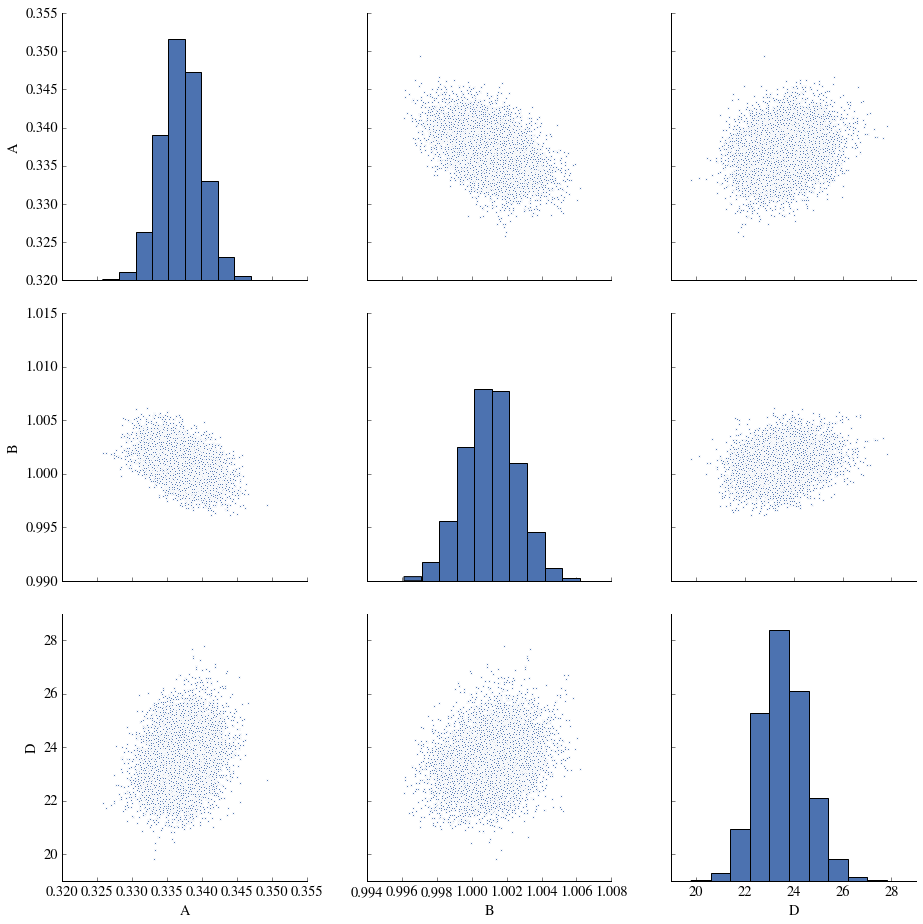

In [18]:
# How do the two peaks correspond to the linear graph in other analysis

# Seperating out A into A1, A2, A3, A4, 
sns.pairplot(parameter_samples, markers='.', size=4.3)
plt.tight_layout()